# Análise de Cancelamentos  de clientes de Telecomunicações

Negócios que oferencem serviços por assinatura, como no caso dos setores de telecomunicação, devem focar em expansão e retenção de sua base de cliente para garantir crescimento e sucesso nas suas atividades. O grande desafio dessas empresas é evitar os cancelamentos de sua base de clientes, popularmente conhecido como churn.

O nosso objetivo como analista de dados é fornecer insumos analíticos para ajudar as empresas nas tomadas decisão com o objetivo de minimizar o churn.

Para isso, devemos responder algumas perguntas em nossa análise:
 - Quais os principais causadores dos cancelamentos?
 - Qual o perfil dos clientes estamos perdendo? E como podemos matê-los?
 - Que medidas a empresa 
 
A base de dados foi retirado do banco de dados da Kaggle: https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics

## Carregar bases de dados e Bibliotecas

In [30]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('archive\\telecom_customer_churn.csv')

## Iniciando as Análises

In [31]:
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

In [33]:
df['Customer ID'].nunique()

7043

Na etapa de limpeza e preparação dos dados o objetivo é entender se os dados estão prontos ou não para análise.
Previamente verificamos que não clientes com ID's repetidos ou com algum formato inconsistente.
Existe algumas colunas com valores nulos mas são especificos de situações onde não existe ocorrencia daquela feature.

Agora vamos verificar como a base está distribuída em seu indicador alvo.

In [34]:
status_counts = df['Customer Status'].value_counts().reset_index()
status_counts.columns = ['Customer Status', 'Count']
total = status_counts['Count'].sum()
status_counts['Percent'] = status_counts['Count'] / total * 100
status_counts['Percent'] = status_counts['Percent'].apply(lambda x: f'{x:.2f}%')
status_counts

,Customer Status,Count,Percent
0,Stayed,4720,67.02%
1,Churned,1869,26.54%
2,Joined,454,6.45%


In [35]:
churn = df[df['Customer Status'] == "Churned"]
valor_churn = churn['Monthly Charge'].sum() * 12

print(f"Perda em U$ de {valor_churn:.2f}")

Perda em U$ de 1645039.80


Conforme registrado acima a base se divide em três categorias o stayed (clientes que permaneceram na base), churned (clientes que saíram da base) e Joined (clientes que entraram na base). 
Verifica-se que mais de um quarto da base de cliente estão cancelando o serviço, vamos em busca de entender os motivos.

Com a perda desses clientes a empresa perdeu cerca 1,6 milhão anual para os concorrentes.

### Análise Exploratória

Analisando agora as categorias de churn chegamos aos seguintes resultados:

In [36]:
df_churn = df[df["Customer Status"] == "Churned"]
churn_counts = df_churn['Churn Category'].value_counts().reset_index()
churn_counts.columns = ['Churn Category', 'Count']
total = churn_counts['Count'].sum()
churn_counts['Percent'] = churn_counts['Count'] / total * 100
churn_counts['Percent'] = churn_counts['Percent'].apply(lambda x: f'{x:.2f}%')

churn_counts

,Churn Category,Count,Percent
0,Competitor,841,45.00%
1,Dissatisfaction,321,17.17%
2,Attitude,314,16.80%
3,Price,211,11.29%
4,Other,182,9.74%


Entemos que o principal motivo de cancelamento dos clientes é relacionado ao competidor. Mas como especificamente o competidor ocasiona os canelamentos?
Vamos agor analisar as razões de cancelamento:

In [37]:
# Contar as ocorrências de cada motivo de churn
churn_reason_counts = df['Churn Reason'].value_counts().reset_index()
churn_reason_counts.columns = ['Churn Reason', 'Count']
total = churn_reason_counts['Count'].sum()
churn_reason_counts['Percent'] = churn_reason_counts['Count'] / total * 100
churn_reason_counts['Percent'] = churn_reason_counts['Percent'].apply(lambda x: f'{x:.2f}%')
churn_reason_counts

,Churn Reason,Count,Percent
0,Competitor had better devices,313,16.75%
1,Competitor made better offer,311,16.64%
2,Attitude of support person,220,11.77%
3,Don't know,130,6.96%
4,Competitor offered more data,117,6.26%
5,Competitor offered higher download speeds,100,5.35%
6,Attitude of service provider,94,5.03%
7,Price too high,78,4.17%
8,Product dissatisfaction,77,4.12%
9,Network reliability,72,3.85%


Só de observar os cinco primeiros motivos de cancelamento entendemos que a oferta dos serviços e produtos dos concorrentes agregam quase 40% de todas as razões pelo cancelamento.
Mas temos que entender por qual motivo a oferta dos produtos e serviços dos concorrentes são melhores que a da Maven Telecon.

Para isso vamos analisar um conjunto de gráficos com as características categóricas dos nossos clientes.


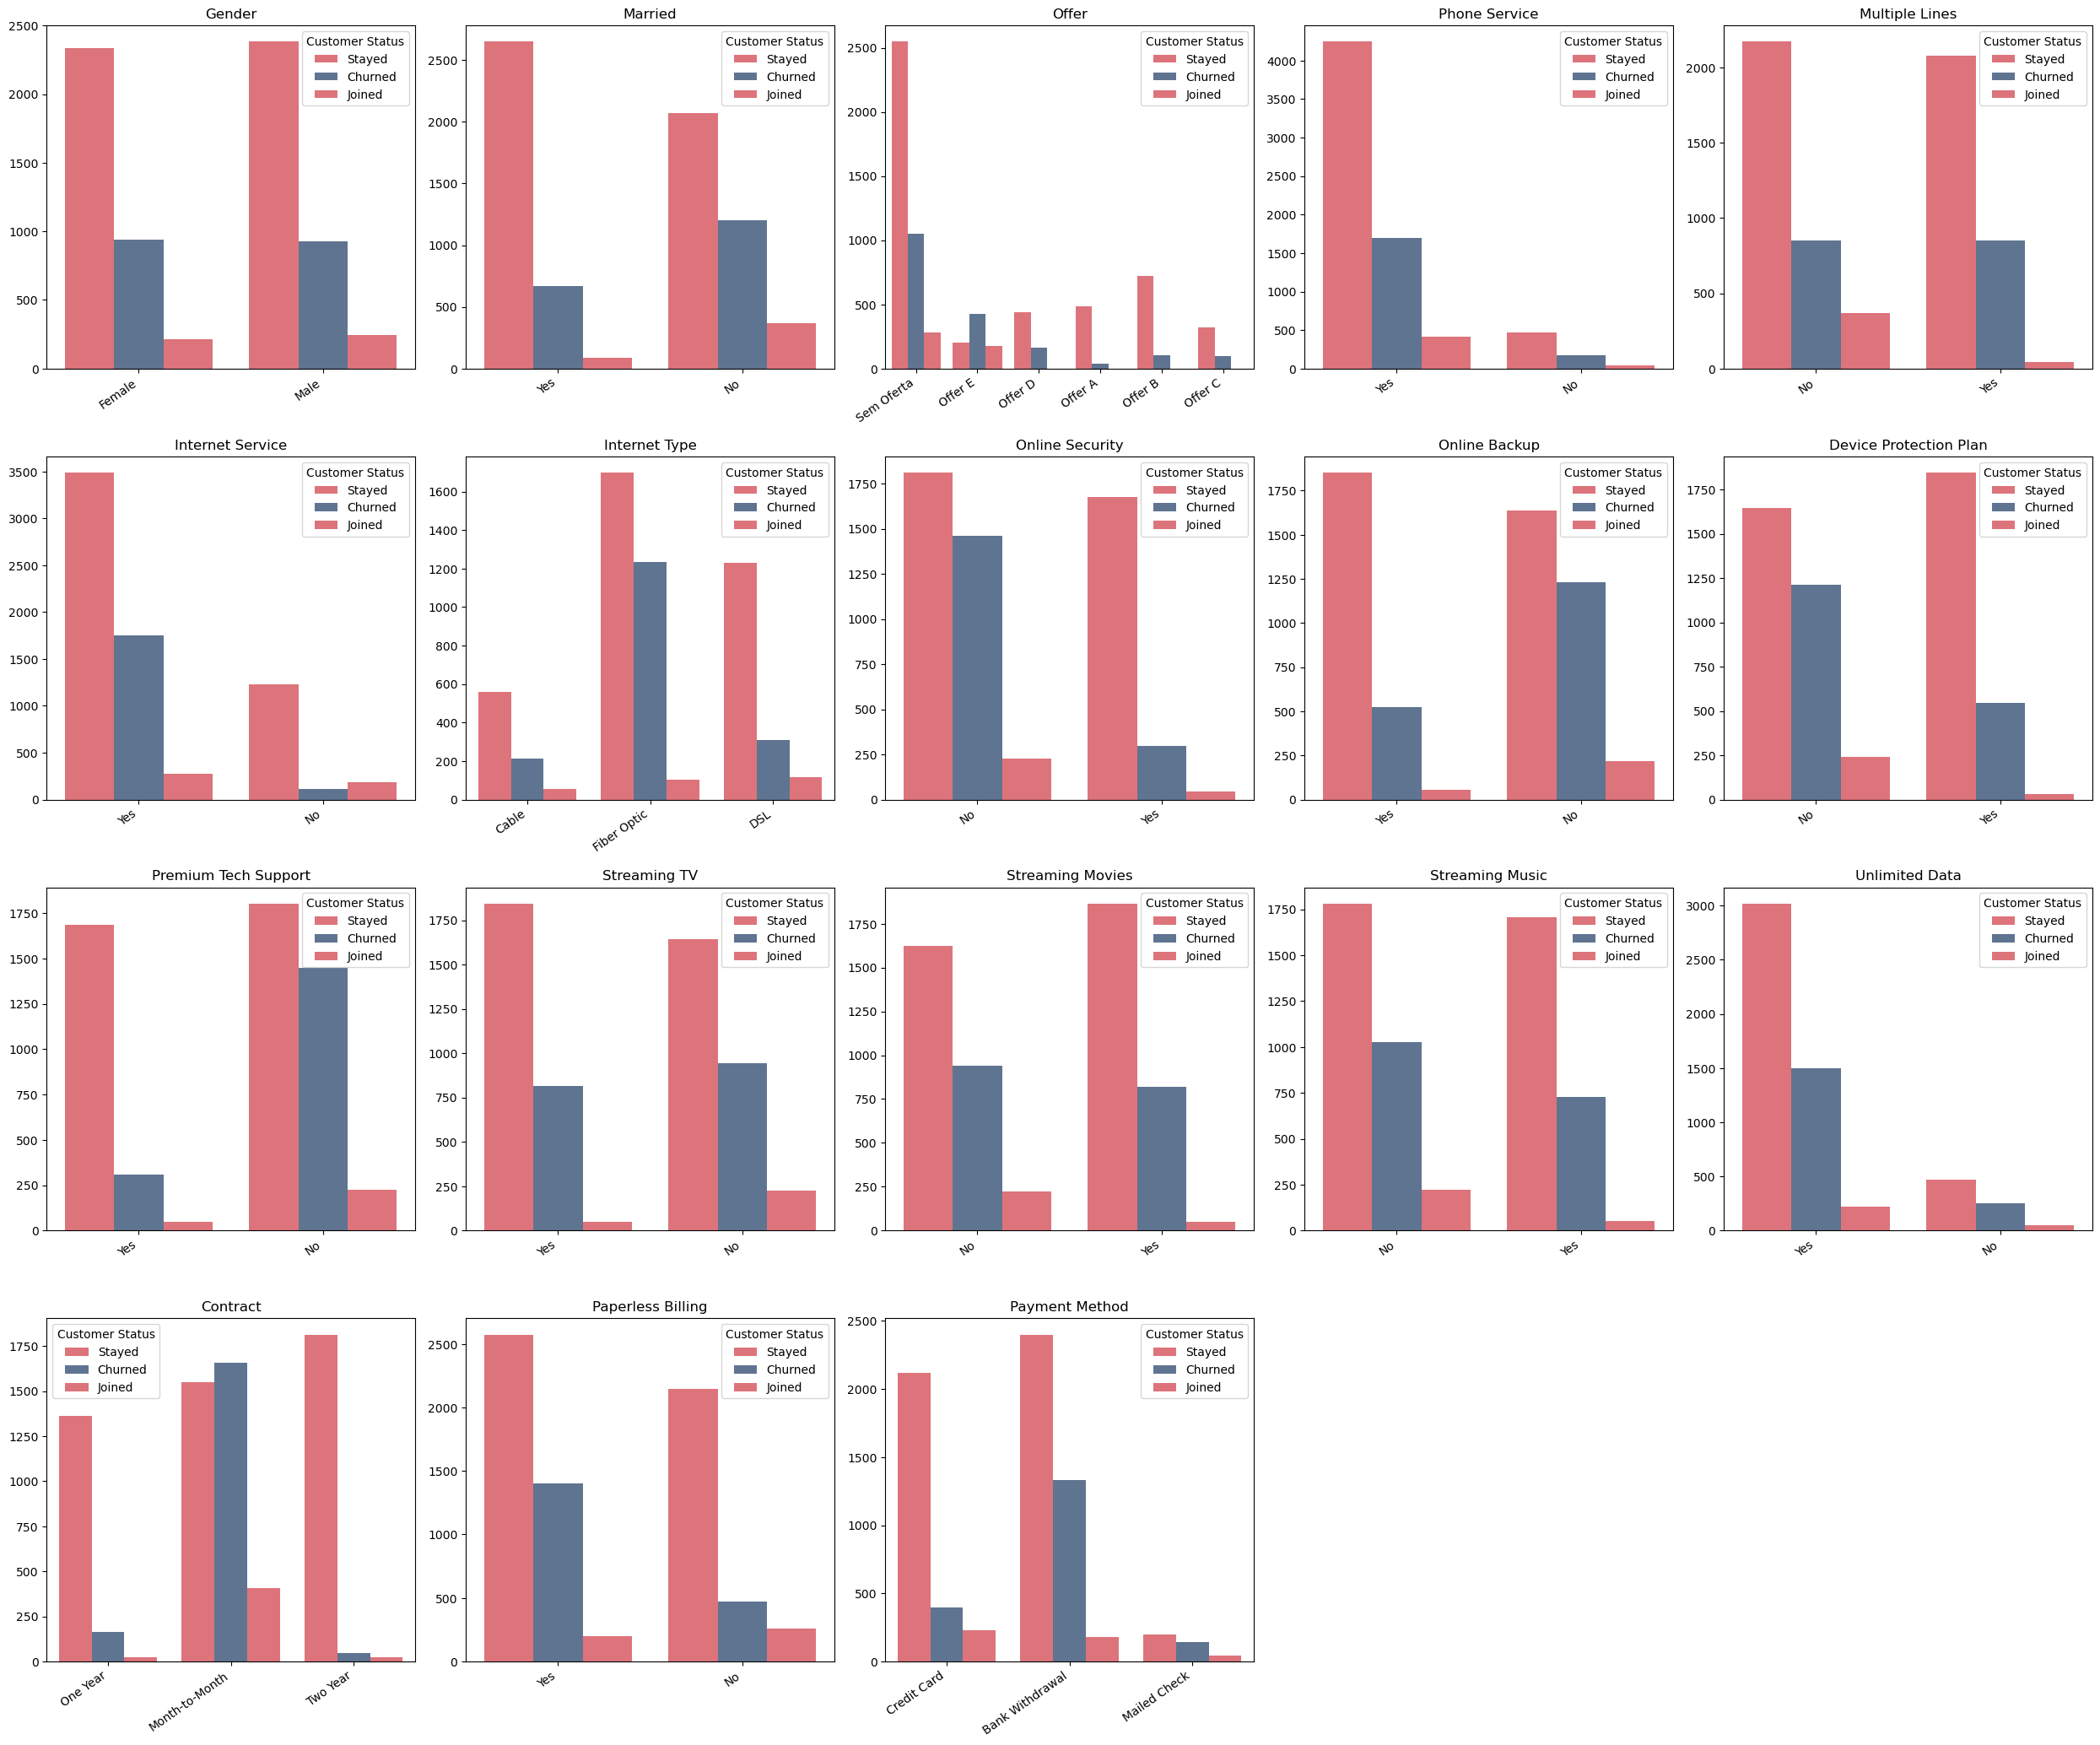

In [38]:
# Preenchendo valores nulos na coluna 'Offer'
df['Offer'].fillna("Sem Oferta", inplace=True)

# Separando as colunas categóricas e retirando as análises já realizadas
cat = list(df.select_dtypes(include='object').columns)
cat.remove("City")
cat.remove("Churn Category")
cat.remove("Churn Reason")
cat.remove("Customer ID")

# Criar a figura do matplotlib para os gráficos de barras
fig1 = plt.figure(figsize=(25, 25))
data_cat = df[cat]
i = 1
for x in cat[:-1]:
    plt.subplot(5, 5, i)
    ax = sns.countplot(data=data_cat, x=data_cat[x], hue='Customer Status', palette=["#EF626C", '#577399'])
    ax.set(xlabel=None, ylabel=None)
    plt.title(str(x), loc='center')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
    i += 1

plt.tight_layout()
plt.savefig("graficos_categoria.png")
plt.show()

Entre várias evidências apresentadas acima vamos destacar alguns pontos importantes:
- Um dos principais destaques observados nos gráficos foi a seção de Ofertas, onde um grande número de clientes não possui nenhum tipo de oferta. Esse fator pode ser fundamental
              para explicar o alto volume de cancelamentos da categoria competidor, pois clientes sem oferta não têm incentivos para permanecer, tornando-os suscetíveis a serem atraídos por
              ofertas de concorrentes.
- Um ponto de atenção específico são as Ofertas E. Talvez seja necessário repensar essa oferta ou até mesmo considerar sua substituição ou cancelamento.
- Os serviços de Telefonia e Internet são os que mais apresentam cancelamentos, o que sugere uma possível correlação entre clientes sem ofertas e aqueles que optam pela Oferta E nesses serviços.
- No Serviço de Internet, a categoria que mais é cancelada é o serviço de fibra óptica.
- Alguns serviços apresentam baixa probabilidade de cancelamento, como Backup Online, Plano de Proteção de Dispositivo, Suporte Premium, Streaming de TV, Streaming de Filmes e Streaming de Músicas.
- Contratos mensais tem grande chance de cancelamentos

Para melhorar nossa percepção diante dos pontos apresentados anteriormente vamos analisar agora as informações de tipos numéricos da base de clientes.

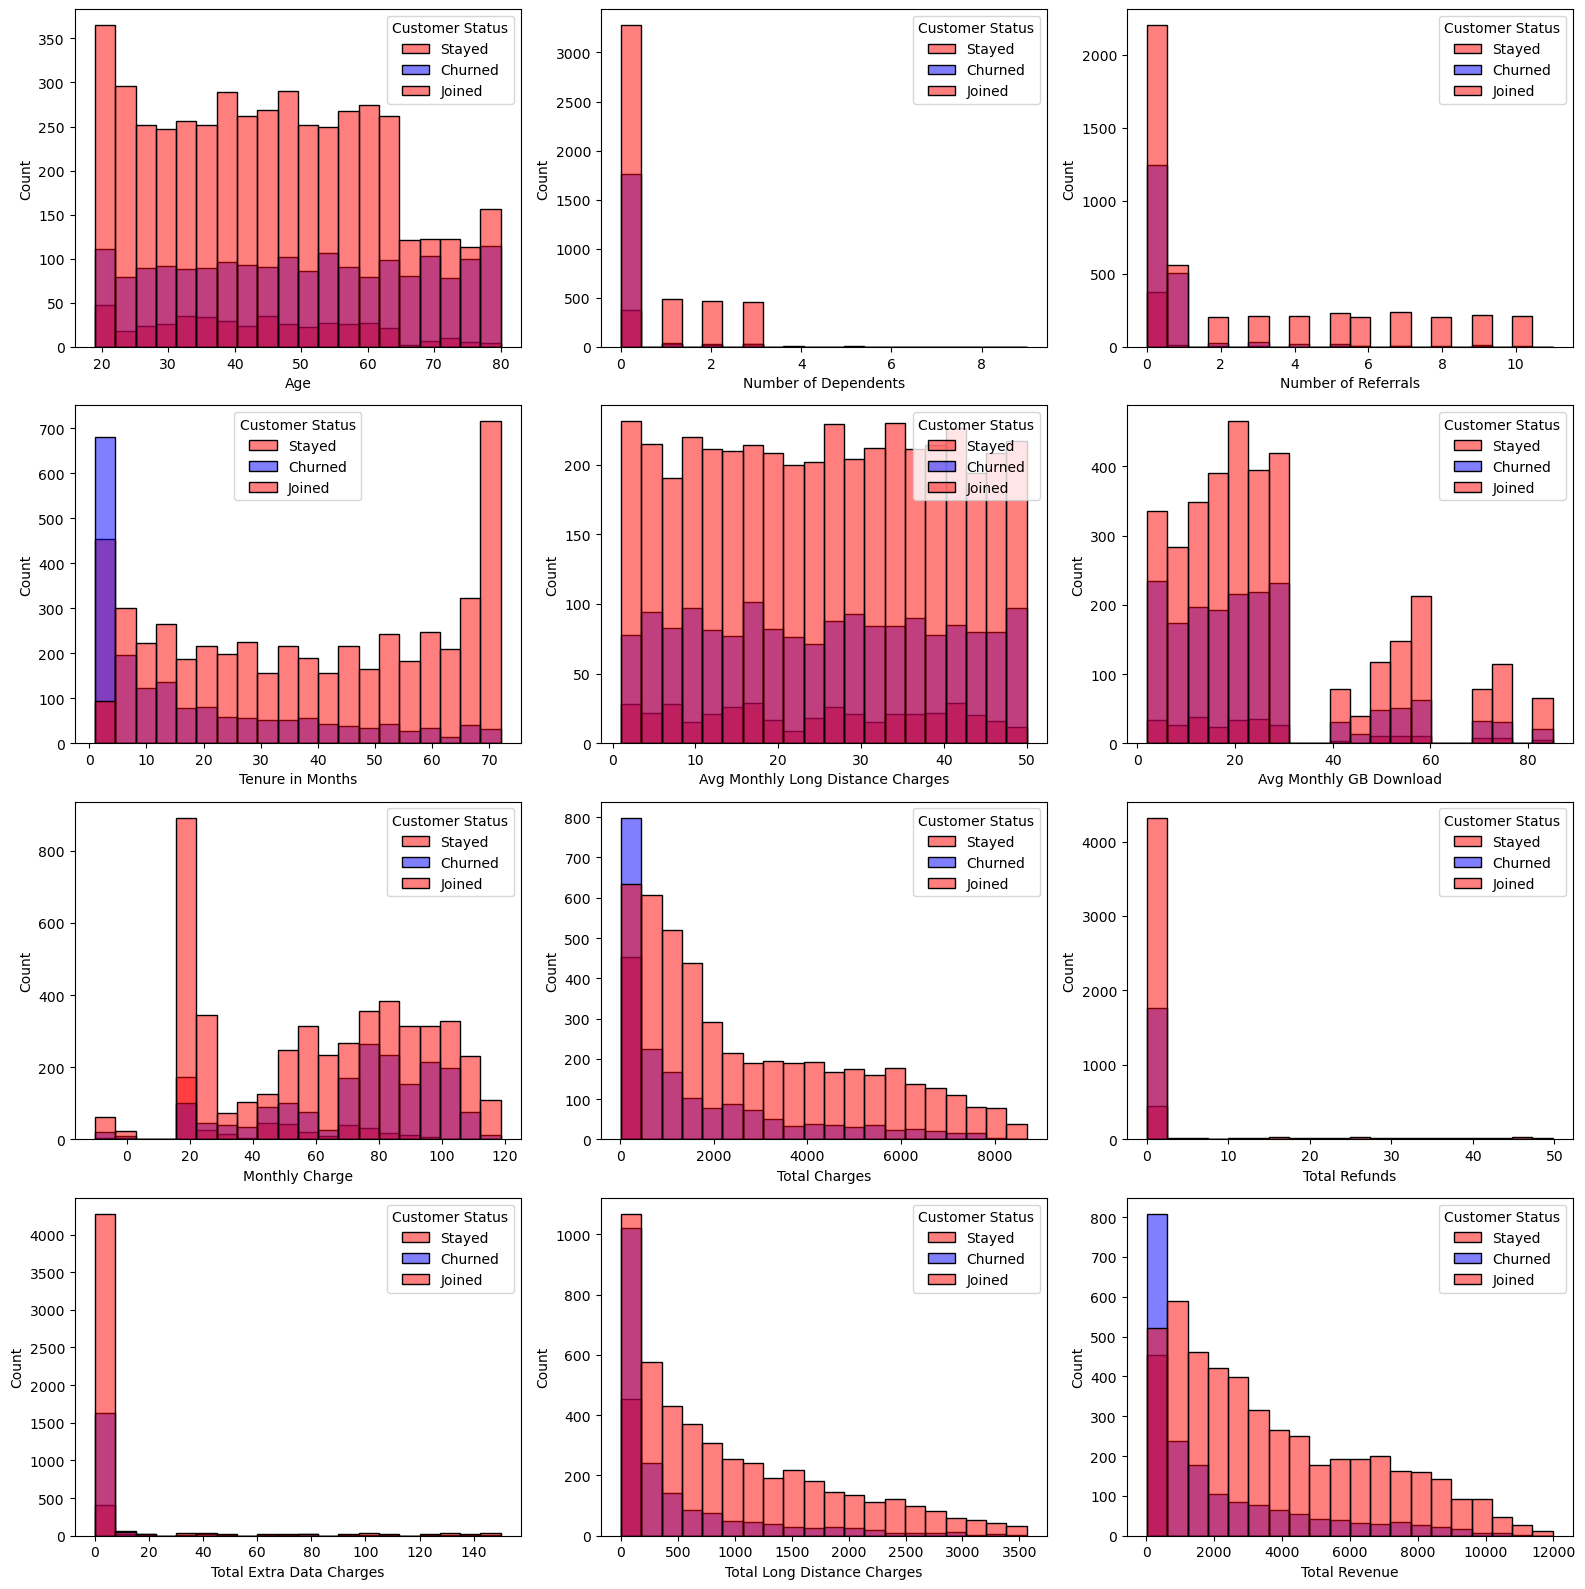

In [40]:
# Importações necessárias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Separando os dados numéricos para análise
num = list(df.select_dtypes(exclude='object').columns)
num.remove("Zip Code")
num.remove("Latitude")
num.remove("Longitude")

# Calculando o número de linhas e colunas para os subplots
n = len(num)
cols = 3
rows = math.ceil(n / cols)

# Criando os subplots
fig5, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Flatten axes para iteração
axes = axes.flatten()
palette = ['#FF0000', '#0000FF'] 

for i in range(n):
    sns.histplot(x=df[num[i]], hue=df['Customer Status'], palette=palette, bins=20, ax=axes[i])

# Remover subplots extras
for j in range(n, len(axes)):
    fig5.delaxes(axes[j])

# Ajuste de layout
fig5.tight_layout()
plt.savefig("graficos_num.png")
plt.show()

- Primeiro destaque é tempo de permanencia dos clientes que cancelam, maior parte dos cancelamentos ocorre dentro
   dos dez primeiros meses.
- A permanencia do cliente obviamente influencia tanto no total de cobrança do cliente quanto também o total de receita 
   que o cleinte gera no total.
- O gráfico de mensalidade indica que quanto maior a mensalidade maior a incidência de cancelamentos quando comparado com
   outros valores de mensalidade.
- Quando temos as informações de permanencia e mensalidade juntas, chegamos a conclusão que os clientes com menos tempo de permanencia 
   possuem mensalidades superiores aos que permanecem por mais tempo.

Vamos tentar deixar a última afirmação feita acima mais clara para fins de análise. Vamos criar uma coluna com o nome 'mensal acima' para verificar se o valor da mensalidade nos clientes que cancelaram está abaixo ou acima da média da base geral de clientes.

In [47]:
df2 = df[df['Customer Status'] == 'Churned']
df2['mensal acima'] = np.where( df2['Monthly Charge'] >  df['Monthly Charge'].mean(), "Acima da Média", "Abaixo da Média" )

contagem_cat  = df2['mensal acima'].value_counts().reset_index()
contagem_cat.columns = ['Categoria', 'Count']

total_ofertas = contagem_cat['Count'].sum()
contagem_cat['Percentage'] = (contagem_cat['Count'] / total_ofertas) * 100
contagem_cat

,Categoria,Count,Percentage
0,Acima da Média,1344,71.910112
1,Abaixo da Média,525,28.089888


Conforme a tabela acima observamos que mais de 70% da base de cancelados possuem mensalidade acima da média dos clientes totais.
Agora vamos observar quais das ofertas estão gerando as mensalidades acima da média total.

In [48]:
ofertas = df2[df2['mensal acima'] == "Acima da Média"]
contagem_ofertas  = ofertas['Offer'].value_counts().reset_index()
contagem_ofertas.columns = ['Offer', 'Count']

total_ofertas = contagem_ofertas['Count'].sum()
contagem_ofertas['Percentage'] = (contagem_ofertas['Count'] / total_ofertas) * 100

contagem_ofertas

,Offer,Count,Percentage
0,Sem Oferta,770,57.291667
1,Offer E,250,18.601190
2,Offer D,122,9.077381
3,Offer B,84,6.250000
4,Offer C,84,6.250000
5,Offer A,34,2.529762


Conforme na tabela acima os clientes sem oferta e com a oferta E somam juntas mais de 75% das mensalidades com ofertas acima da média total.

## Análise do Perfil de Cliente que Cancelaram

Um cliente de alto valor é aquele que:
 - É um cliente leal (estão na empresa a pelo menos 10 meses)
 - Traz bons retornos (possuem o valor mensalidade superior a mediana)
 - Indica outros clientes para a empresa. 

In [44]:
median = df['Monthly Charge'].median()

def calcular_valor(row):
    condicoes = [
        row['Tenure in Months'] >= 10,
        row['Monthly Charge'] > median,
        row['Number of Referrals'] > 0
    ]
    verdadeiros = sum(condicoes)
    
    if verdadeiros == 3:
        return 'Alto Valor'
    else:
        return 'Normal'
    
churn = df[df['Customer Status'] == "Churned"]

churn['Tipo_Cliente'] =  churn.apply(calcular_valor, axis=1)

churn['Tipo_Cliente'].value_counts(normalize=True) * 100

Tipo_Cliente
Normal        81.166399
Alto Valor    18.833601
Name: proportion, dtype: float64

Aproximadamente cerca de 19% dos clientes que cancelaram o serviço são clientes considerados de alto valor.

#### Qual o risco de saída dos clientes que permaceram?

Levando em consideração os gráficos de categorias utilizarei como critério para classificar os clientes de alto risco possuir ofertas E e não ter ofertas, possuir contrato mensal, Não ter suporte premium e possuir o serviço de fibra óptica

Clientes que possuem de 3 a 4 dos critérios especificadps são considerados de alto risco de cancelamento, clientes com duas condições atendidas são considerados de Médio Risco e por fim clientes que possuem apenas uma das condições estabelecidas são considerados de baixo risco. 

In [45]:
# Função para calcular o risco
def calcular_risco(row):
    condicoes = [
        (pd.notnull(row['Offer']) and row['Offer'] == "Offer E"),
        row['Contract'] == 'Month-to-Month',
        row['Premium Tech Support'] == 'No',
        row['Internet Type'] == 'Fiber Optic'
    ]
    verdadeiros = sum(condicoes)
    
    if verdadeiros == 1:
        return 'Baixo Risco'
    elif verdadeiros == 2:
        return 'Risco Médio'
    else:
        return 'Alto Risco'
    
stay = df[df['Customer Status'] == 'Stayed']

stay['risk'] = stay.apply(calcular_risco, axis=1)

contagem_clientes = stay['risk'].value_counts().reset_index()
contagem_clientes.columns = ['Risco', 'Count']

# Calcula o percentual de cada oferta
total_clientes = contagem_clientes['Count'].sum()
contagem_clientes['Percentage'] = (contagem_clientes['Count'] / total_clientes) * 100
contagem_clientes

,Risco,Count,Percentage
0,Alto Risco,2344,49.661017
1,Baixo Risco,1296,27.457627
2,Risco Médio,1080,22.881356


A tabela acima identifica que quase 50% da base de clientes que ficaram possuem alto risco de se tornarem churn

É importante saber também os clientes de alto valor estão em risco de cancelarem o serviço.

In [46]:
risco_valor = df[df['Customer Status'] == 'Stayed']
risco_valor['Tipo_Cliente'] = risco_valor.apply(calcular_valor, axis=1)
risco_valor = risco_valor[risco_valor['Tipo_Cliente'] == 'Alto Valor'] 
risco_valor['risk'] = risco_valor.apply(calcular_risco, axis=1)

contagem_clientes = risco_valor['risk'].value_counts().reset_index()
contagem_clientes.columns = ['Risco', 'Count']

# Calcula o percentual de cada oferta
total_clientes = contagem_clientes['Count'].sum()
contagem_clientes['Percentage'] = (contagem_clientes['Count'] / total_clientes) * 100
contagem_clientes

,Risco,Count,Percentage
0,Alto Risco,459,37.135922
1,Baixo Risco,405,32.766990
2,Risco Médio,372,30.097087


### Insights 

- A empresa perdeu 1869 clientes que representa cerca de 26.5% da base total de clientes e que corresponde a aproximadamente 1,6 milhão de reais anual.
- A principal razão de cancelameto dos clientes é relacionado as ofertas de serviços e produtos dos concorrentes e também relacionado ao suporte interno.
- Os principais indicadores de rotatividade são o contrato mensal, ausência de suporte técnico premium, internet de fibra óptica, ausência de ofertas promocionais e o tipo de oferta E.
- Com base nos principais indicadores de cancelamento, dos 1236 clientes de alto valor que permaneceram na empresa cerca de 37% correm alto risco de cancelarem

### Ações Estratégicas

- Programas de fidelidade para clientes de alto valor
- Investimento em T&D para a equipe de suporte
- Melhorar o serviço de fibra óptica
- Desenvolver estratégias comerciais voltadas para clientes em cada tipo de risco
- Implementar processos de jornada do cliente focados em rentenção (Pós-Venda por exemplo)